<a href="https://colab.research.google.com/github/DrHB/PyTorch-Course/blob/main/Intro-PyTorch-3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to PyTorch Part 3

> by Habib Bukhari and Roman Vaxenburg

In this notebook we will build an image classifier using the **transfer learning** approach. The task will be to classify images of flowers. As a main part of our model we will use a pre-trained convolutional neural network trained on a similar but more complicated task -- classifying 1000 classes of images. We will also touch upon data augmentation and selection some of the model hyperparameters.

1. Downloading data
2. Building `dataset` and `dataloader`
3. Building the model
4. Training
5. Data augmentation

```python 
#only on colab
#Run once per session
!pip install fastai -q --upgrade
```

Make sure your `gpu` is working navigate to `Edit` -> `Notebook settings` - > `Hardware accelerator` and select `GPU` click `SAVE`

In [1]:
# Run this cell only on Colab
!pip install fastai -q --upgrade

     |████████████████████████████████| 194kB 12.6MB/s 
     |████████████████████████████████| 61kB 5.8MB/s 


In [2]:
#downloading the data
from fastai.vision.all import untar_data, URLs, Path, show_image, get_image_files
from fastai.vision.all import DataLoaders, DataLoader
import PIL
import re
import random
import pandas as pd
!pip install fastdot -q
from fastdot import *
import numpy as np
import torch
import matplotlib.pyplot as plt

# Setting up the project 

For our classification task we will be using the `Oxford 102 Flowers` dataset. This set contains images of flowers belonging to 102 different categories. The images were acquired by searching the web and taking pictures. Before the data is split into train/validations/test subsets, each class consist of between 40 and 258 images.

http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html

http://www.robots.ox.ac.uk/~vgg/data/flowers/102/categories.html

## 1. Downloading data

Let's download the data first

In [3]:
path = untar_data(URLs.FLOWERS)

In [4]:
path

Path('/root/.fastai/data/oxford-102-flowers')

Let's see what's in the data folder

In [5]:
for i in path.ls(): 
    print(i.name)

jpg
train.txt
valid.txt
test.txt


Each image is stored as a separate file in the `/jpg` directory. Let's see how many images there are in the directory

In [6]:
list_of_all_images = list(Path(path/'jpg').iterdir())

In [7]:
list_of_all_images[:5]

[Path('/root/.fastai/data/oxford-102-flowers/jpg/image_05807.jpg'),
 Path('/root/.fastai/data/oxford-102-flowers/jpg/image_02198.jpg'),
 Path('/root/.fastai/data/oxford-102-flowers/jpg/image_05046.jpg'),
 Path('/root/.fastai/data/oxford-102-flowers/jpg/image_00177.jpg'),
 Path('/root/.fastai/data/oxford-102-flowers/jpg/image_06327.jpg')]

In [8]:
print (f'total number of images: {len(list_of_all_images)}')

total number of images: 8189


Let's take a look into the `.txt` files. We will open them using `pandas` and rename the columns to `fn` - full path where file is located, and `labels` - corresponding label

In [9]:
path/'train.txt'

Path('/root/.fastai/data/oxford-102-flowers/train.txt')

At first, let's read the `train.txt` file and take a look at it

In [10]:
df_train = pd.read_csv(path/'train.txt', header=None, sep=" ")
df_train

,0,1
0,jpg/image_03860.jpg,16
1,jpg/image_06092.jpg,13
2,jpg/image_02400.jpg,42
3,jpg/image_02852.jpg,55
4,jpg/image_07710.jpg,96
...,...,...
1015,jpg/image_02944.jpg,59
1016,jpg/image_07434.jpg,93
1017,jpg/image_02684.jpg,57
1018,jpg/image_01639.jpg,81


Let's rename the columns to `fn` and `labels`

In [11]:
df_train.columns = ['fn', 'labels']
df_train.head()

,fn,labels
0,jpg/image_03860.jpg,16
1,jpg/image_06092.jpg,13
2,jpg/image_02400.jpg,42
3,jpg/image_02852.jpg,55
4,jpg/image_07710.jpg,96


And now replace the `fn` entries with the full paths like this:

In [12]:
df_train['fn'] = df_train['fn'].apply(lambda x: path/x)
df_train.head()

,fn,labels
0,/root/.fastai/data/oxford-102-flowers/jpg/image_03860.jpg,16
1,/root/.fastai/data/oxford-102-flowers/jpg/image_06092.jpg,13
2,/root/.fastai/data/oxford-102-flowers/jpg/image_02400.jpg,42
3,/root/.fastai/data/oxford-102-flowers/jpg/image_02852.jpg,55
4,/root/.fastai/data/oxford-102-flowers/jpg/image_07710.jpg,96


The training dataframe is ready to use!

Let's do the same with the `valid.txt` and `test.txt` files

In [13]:
df_valid = pd.read_csv(path/'valid.txt', header=None, sep=" ")
df_valid.columns = ['fn', 'labels']
df_valid['fn'] = df_valid['fn'].apply(lambda x: path/x)

df_test = pd.read_csv(path/'test.txt', header=None, sep=" ")
df_test.columns = ['fn', 'labels']
df_test['fn'] = df_test['fn'].apply(lambda x: path/x)

In [14]:
df_valid.head()

,fn,labels
0,/root/.fastai/data/oxford-102-flowers/jpg/image_04467.jpg,89
1,/root/.fastai/data/oxford-102-flowers/jpg/image_07129.jpg,44
2,/root/.fastai/data/oxford-102-flowers/jpg/image_05166.jpg,4
3,/root/.fastai/data/oxford-102-flowers/jpg/image_07002.jpg,34
4,/root/.fastai/data/oxford-102-flowers/jpg/image_02007.jpg,79


In [15]:
df_test.head()

,fn,labels
0,/root/.fastai/data/oxford-102-flowers/jpg/image_06977.jpg,34
1,/root/.fastai/data/oxford-102-flowers/jpg/image_00800.jpg,80
2,/root/.fastai/data/oxford-102-flowers/jpg/image_05038.jpg,58
3,/root/.fastai/data/oxford-102-flowers/jpg/image_06759.jpg,0
4,/root/.fastai/data/oxford-102-flowers/jpg/image_01133.jpg,45


Let's print the shapes to see the number of images in each dataset

In [16]:
print('df_train:', df_train.shape)
print('df_valid:', df_valid.shape)
print('df_test: ', df_test.shape)

df_train: (1020, 2)
df_valid: (1020, 2)
df_test:  (6149, 2)


Now let's examine the flower images

In [17]:
one_file_name = df_train.iloc[0]['fn'] # get the filename of the image in the 0-th row

In [18]:
one_file_name

Path('/root/.fastai/data/oxford-102-flowers/jpg/image_03860.jpg')

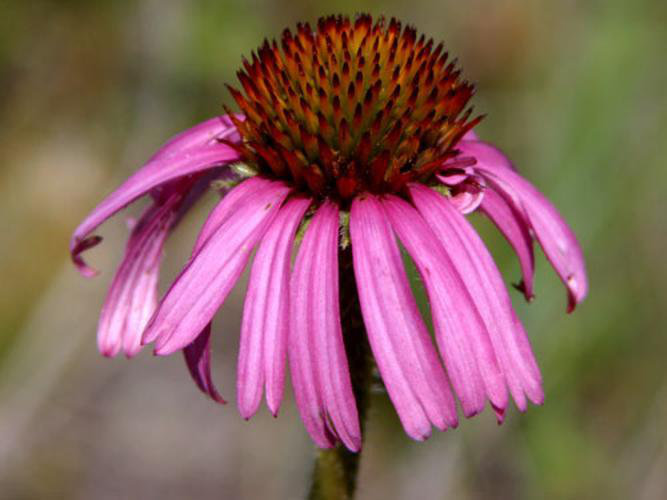

In [19]:
PIL.Image.open(one_file_name)

Let's define a small function to return the label from the dataframe row

In [20]:
def get_label(row):
    return row.labels.item()

def open_image(row):
    fn = row.fn.item()
    return PIL.Image.open(fn)

In [21]:
one_row  = df_train.sample(1)
one_row

,fn,labels
350,/root/.fastai/data/oxford-102-flowers/jpg/image_05306.jpg,69


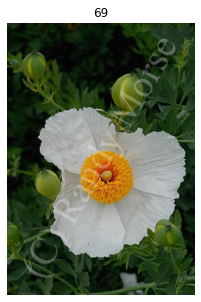

In [22]:
show_image(open_image(one_row), title = get_label(one_row))


You can read more about the classes and labels here http://www.robots.ox.ac.uk/~vgg/data/flowers/102/categories.html

Let's explore the data a bit more and see how the data is distributed among the different classes

In [23]:
df_train.head()

,fn,labels
0,/root/.fastai/data/oxford-102-flowers/jpg/image_03860.jpg,16
1,/root/.fastai/data/oxford-102-flowers/jpg/image_06092.jpg,13
2,/root/.fastai/data/oxford-102-flowers/jpg/image_02400.jpg,42
3,/root/.fastai/data/oxford-102-flowers/jpg/image_02852.jpg,55
4,/root/.fastai/data/oxford-102-flowers/jpg/image_07710.jpg,96


We have 102 flower classes:

In [24]:
df_train['labels']


0       16
1       13
2       42
3       55
4       96
        ..
1015    59
1016    93
1017    57
1018    81
1019    10
Name: labels, Length: 1020, dtype: int64

In [25]:
df_train['labels'].unique().shape


(102,)

Text(0, 0.5, 'Number of images')

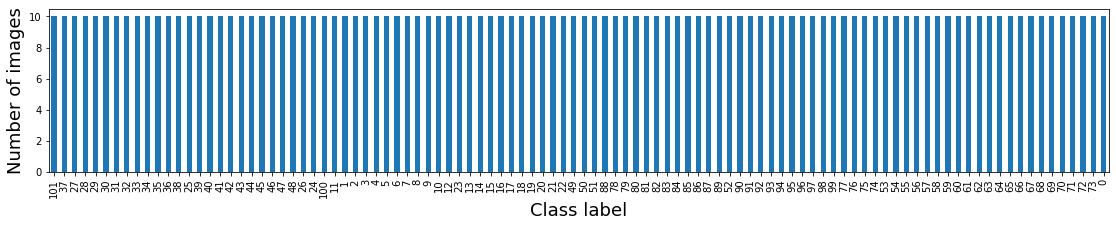

In [26]:
# Seems like we have a pretty even distribution
ax = df_train['labels'].value_counts().plot.bar(figsize=(19, 3))
ax.set_xlabel('Class label', fontsize=18)
ax.set_ylabel('Number of images', fontsize=18)

#### None on preparing labels

Many machine learning algorithms cannot operate on data labels directly, unless the labels are numeric as in out flower classification project. In general, this is mostly a constraint of the efficient implementation of machine learning algorithms rather than hard limitations on the algorithms themselves. This means that categorical data must be converted to a numerical form. If the categorical variable is an output variable, you may also want to convert predictions by the model back into a categorical form in order to present them or use them in some application. 

https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/

## 2. Building `dataset` and `dataloader`

So far we have organized the data in the correct format. Now let's build dataloader to pass this data to the model during training and validation.

In [27]:
fn = df_train.iloc[0]['fn'] # get the filename of the image in the 0-th row
fn

Path('/root/.fastai/data/oxford-102-flowers/jpg/image_03860.jpg')

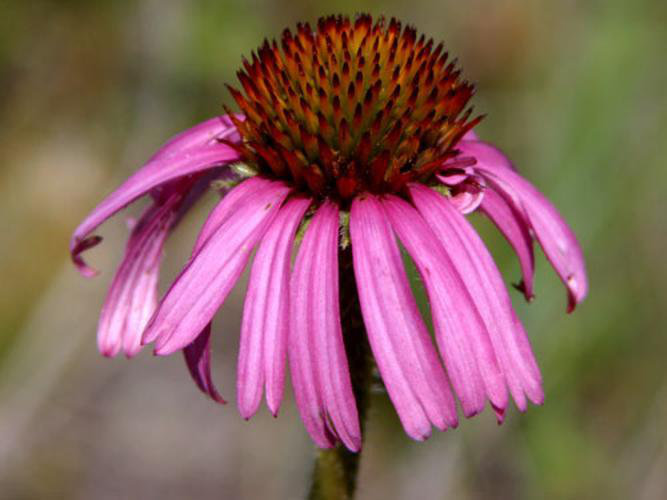

In [28]:
img = PIL.Image.open(fn)
img

The images have another attribute: their size.

In [29]:
img.size

(667, 500)

Let's add a new column with size information to our dataframe

In [30]:
def get_size(fn: Path):
    img = PIL.Image.open(fn)
    return img.size

df_train['size'] = df_train['fn'].map(get_size) # Add new column

In [31]:
df_train.head()

,fn,labels,size
0,/root/.fastai/data/oxford-102-flowers/jpg/image_03860.jpg,16,"(667, 500)"
1,/root/.fastai/data/oxford-102-flowers/jpg/image_06092.jpg,13,"(500, 638)"
2,/root/.fastai/data/oxford-102-flowers/jpg/image_02400.jpg,42,"(500, 667)"
3,/root/.fastai/data/oxford-102-flowers/jpg/image_02852.jpg,55,"(656, 500)"
4,/root/.fastai/data/oxford-102-flowers/jpg/image_07710.jpg,96,"(500, 601)"


Note that the images have different size!

Text(0.5, 0, 'image height')

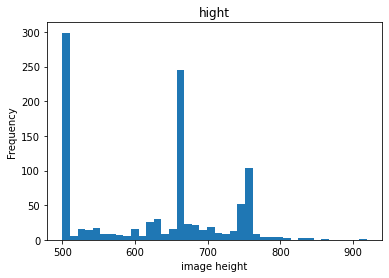

In [32]:
height = df_train['size'].apply(lambda x: x[0]) # isolate the first element of size (height)
ax = height.plot.hist(bins=40, title='hight')
ax.set_xlabel('image height')

Text(0.5, 0, 'image width')

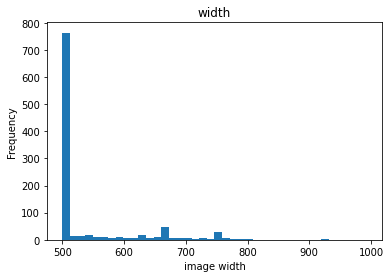

In [33]:
width = df_train['size'].apply(lambda x: x[1]) # isolate the second element of size (width)
ax = width.plot.hist(bins=40, title='width')
ax.set_xlabel('image width')

We have images of diffrent size so we have to convert all images to equal size.

Let's write a small function to help us achieve this

In [34]:
def open_image(fn: Path, sz: int = 224):
    img = PIL.Image.open(fn)
    img = img.resize((sz, sz))
    return img

In [35]:
img = open_image(fn)

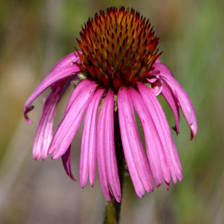

In [36]:
img

In [37]:
img.size

(224, 224)

The image is now square and of correct size. Our `dataloader` will be resizing the images for us on the fly.

###  Transfer Learning

For our classification problem we won't train the model from scratch. Instead, we will utilize an existing powerful neural network that was trained on a similar task -- classification of images, but from different and broader categories. We will modify the architecture of the pre-trained network slightly to match the number of classes in our classification problem. Then we will refine this new modified model by training it on our data. This approach is called **transfer learning**!

https://machinelearningmastery.com/transfer-learning-for-deep-learning/

### Normalizing the images

To properly use the pre-trained network for transfer learning, we will need to normalize the images to match the image statistics the pre-trained network has been trained on.

The pre-trained model expects input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`.

https://pytorch.org/docs/stable/torchvision/models.html


Subtracting the dataset mean serves to "center" the data. Additionally, you ideally would like to divide by the sttdev of that feature or pixel as well if you want to normalize each feature value to a z-score. 

The reason we do both of those things is because in the process of training our network, we're going to be multiplying (weights) and adding to (biases) these initial inputs in order to cause activations that we then backpropogate with the gradients to train the model. We'd like in this process for each feature to have a similar range so that our gradients don't go out of control (and that we only need one global learning rate multiplier). 

Another way you can think about it is deep learning networks traditionally share many parameters - if you didn't scale your inputs in a way that resulted in similarly-ranged feature values (ie: over the whole dataset by subtracting mean) sharing wouldn't happen very easily because to one part of the image weight w is a lot and to another it's too small. 

You will see in some CNN models that per-image whitening is used, which is more along the lines of your thinking. https://stats.stackexchange.com/questions/211436/why-normalize-images-by-subtracting-datasets-image-mean-instead-of-the-current

In [38]:
# imagenet pretrained network
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [39]:
df_valid.iloc[0]['fn']

Path('/root/.fastai/data/oxford-102-flowers/jpg/image_04467.jpg')

Let's write a class that will take an image file with a specified index, resize the image, rescale and renormalize it, and return it with its corresponding label as `(image, label)`

In [40]:
def open_image(fn: Path, sz: int = 224):
    img = PIL.Image.open(fn).convert('RGB')
    img = img.resize((sz, sz))
    return img

# dataset 
class FlowerDatset():
    def __init__(self,
                 df: pd.DataFrame, 
                 image_sz: int = 224, 
                 imagenet_stats: tuple = (mean, std)):

        self.df         = df
        self.image_size = image_sz
        self.stats      = imagenet_stats
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path =  self.df.iloc[index]['fn']
        label    =  self.df.iloc[index]['labels']
        img      =  open_image(img_path, sz=self.image_size)
        #scaling between 0 and 1
        img      =  np.array(img)/255
        #normalizing as imagenet does
        img      = (img - self.stats[0]) / self.stats[1]
        img      = torch.tensor(img).permute(2, 0, 1).float() #channel, height, width
        return img, label


Instantiate `train` and `validation` datasets

In [41]:
train_ds = FlowerDatset(df_train, 224, (mean, std))
valid_ds = FlowerDatset(df_valid, 224, (mean, std))

In [42]:
img, label = train_ds[0]

In [43]:
img.shape

torch.Size([3, 224, 224])

In [44]:
label

16

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


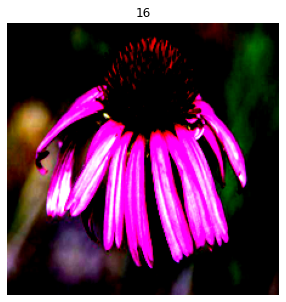

In [45]:
show_image(img, title=label)

In [46]:
print(len(train_ds))
print(len(valid_ds))

1020
1020


Now we are ready to instantiate our dataloaders!

For a good explanation of the `pin_memory` flag see: https://developer.nvidia.com/blog/how-optimize-data-transfers-cuda-cc/

In [47]:
batch_size  = 32
shuffle     = True
num_workers = 2

# Create train dataloader
dl_train    = DataLoader(train_ds,
                         bs=batch_size, 
                         num_workers=num_workers, 
                         drop_last=True,
                         pin_memory=True, 
                         shufle=shuffle)

# Create validation dataloader
dl_valid    = DataLoader(valid_ds,
                         bs=batch_size * 2, # validate on 2x bigger batches  
                         num_workers=num_workers, 
                         drop_last=False,
                         pin_memory=True, 
                         shufle=False)

# Combine train and validation dataloaders
dls = DataLoaders(dl_train, dl_valid, device='cuda')

In [48]:
# Let's get one batch
x, y = dls.one_batch()

In [49]:
print(x.shape) # image tensor of shape (batch_size, channels=3, height, width)
print(y.shape) # label tensor

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [50]:
x.device, y.device

(device(type='cuda', index=0), device(type='cuda', index=0))

The dataloader is ready! Now we are ready to build our model.

## 3. Building the Model

For our transfer learning task we will use `ResNet18`, one of the pre-trained models included in the `torchvision.models` package. The model is pre-trained on the `ImageNet` dataset containing about 14 million images and 1000 classes.

https://pytorch.org/docs/stable/torchvision/models.html

http://image-net.org/about-overview

In [51]:
import torch
import torch.nn as nn

In [52]:
# diffrence between them  
import torchvision.models as models

```python
resnet18 = models.resnet18()
alexnet = models.alexnet()
vgg16 = models.vgg16()
squeezenet = models.squeezenet1_0()
densenet = models.densenet161()
inception = models.inception_v3()
googlenet = models.googlenet()
shufflenet = models.shufflenet_v2_x1_0()
mobilenet = models.mobilenet_v2()
resnext50_32x4d = models.resnext50_32x4d()
wide_resnet50_2 = models.wide_resnet50_2()
mnasnet = models.mnasnet1_0()
```

Let's take the `ResNet18` model

In [53]:
# pretrained=True means that we will load model with imagenet weights
flower_model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


Let's take a look at the model summary

In [54]:
flower_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Note that the model is essentially a sequence of convolutional and occasional pooling layers. These layers gradually transform the input image into a vector of 512 features. Then, a single-layer linear classifier produces a vector with length 1000 of class probabilites based on this feature vector.
```python
Linear(in_features=512, out_features=1000, bias=True)
```

This model is trained on `imagenet` which has 1000 clases. In our case we have 102 classes. So we only have to modify the last linear layer so the output is 102 like this:

```python
Linear(in_features=512, out_features=102, bias=True)
```

In [55]:
num_classes = df_train['labels'].nunique()
num_classes

102

Last layer in the original model

In [56]:
flower_model.fc

Linear(in_features=512, out_features=1000, bias=True)

We will replace this layer with:

In [57]:
nn.Linear(in_features=512, out_features=num_classes)

Linear(in_features=512, out_features=102, bias=True)

In [58]:
flower_model.fc  = nn.Linear(in_features=512, out_features=num_classes) # Actual replacement!
flower_model.fc

Linear(in_features=512, out_features=102, bias=True)

Let's check our modified model

In [59]:
flower_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

The last layer is the one we wanted: it takes in 512 features and produces 102 class probabilities. However, this new layer is not trained yet and has randomly initialized weights. The rest of the network contains trained weight because we've loaded a pre-trained model.

Now we are ready to train!

## 4. Training

Just for convinience we will not write our own training loop. There are many good libraries that take care of training and let you focus on your experiments. We will be using `fastai` training loop.

In [60]:
from fastai.vision.all import Learner, SGD

In [61]:
# define metric
def flatten_check(inp, targ):
    """Check that `inp` and `targ` have the same number of elements and flatten them."""
    inp, targ = inp.contiguous().view(-1), targ.contiguous().view(-1) # flatten tensors
    assert len(inp) == len(targ) # check that sizes are equal
    return inp, targ

# Accuracy measures the fraction of the correct predictions out of total
def accuracy(inp, targ, axis=-1):
    pred, targ = flatten_check(inp.argmax(dim=axis), targ)
    return (pred == targ).float().mean()

Dummy forward pass

In [62]:
# Get input images and correct labels from dataloader
x, y = dls.one_batch()
print(x.shape) # batch of images
print(y.shape) # ground truth labels

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [63]:
# Pass images to model
with torch.no_grad():
    y_pred = flower_model(x.cpu())
y_pred.shape # batch of predicted labels

torch.Size([32, 102])

In [64]:
learn = Learner(dls, # dataloader
                flower_model,
                metrics=[accuracy],
                opt_func= SGD,
                loss_func=nn.CrossEntropyLoss())

### Choosing `learning rate`

Learnig rate is one of the most important parameters in model training. Recall that it determines how fast (or how slow) the model parameters are updated at each training iterations.

We will use an automated way of finding the suitable learning rate value https://docs.fast.ai/callback.schedule#Learner.lr_find

It is based on this paper: https://arxiv.org/abs/1506.01186


SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.10000000149011612)

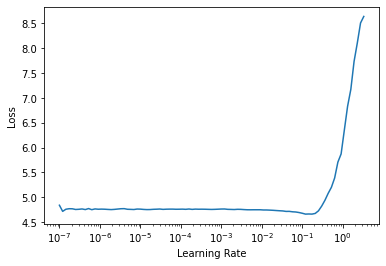

In [65]:
# Learning rate range test
learn.lr_find()

Finaly let's train the model!

In [66]:
learn.fit(n_epoch=10, lr=0.017)

epoch,train_loss,valid_loss,accuracy,time
0,4.368613,3.763966,0.276471,00:22
1,3.532955,2.929049,0.527451,00:22
2,2.748275,2.369175,0.663725,00:22
3,2.071237,1.997716,0.750980,00:22
4,1.516978,1.737498,0.796078,00:22
5,1.087569,1.570872,0.810784,00:22
6,0.771682,1.436720,0.819608,00:22
7,0.548140,1.351789,0.823529,00:22
8,0.394435,1.285322,0.826471,00:22
9,0.290041,1.233265,0.831373,00:22


Wow this is a pretty good result for such a small model and under `2 min` training!

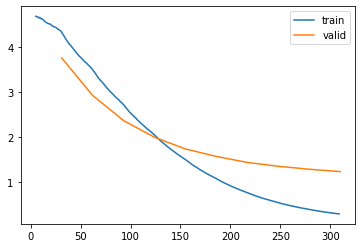

In [67]:
learn.recorder.plot_loss()

Let's take a look at some predictions

In [68]:
x, y = dls.valid.one_batch() # Get one batch from validation dataset
with torch.no_grad():
    y_pred = flower_model(x) # Inference forward pass

print(y.shape)
print(y_pred.shape)

torch.Size([64])
torch.Size([64, 102])


In [69]:
print(f'Predicted classes:\n{y_pred.argmax(dim=-1)}') # predicted classes
print(f'True classes:\n{y}') # true classes
print(y_pred.argmax(dim=-1) == y)
print(f'Correct predictions: {(y_pred.argmax(dim=-1) == y).sum().item()} out of {y.shape[0]}')

Predicted classes:
tensor([ 89,  44,   4,  34,  79,  55,  21,  42,  47,  86,  43,  98,  35,  77,
          5, 100,  14,  27,  65,  66,  43,  61,  20,  13,  69,  91,  48,  24,
         90,  26,  40,  67,  52,  62,   8,  24,  32,  60,  51,  95,  48,   3,
         30,  47,  23,   1,  28,  16,  27,  19,  85,   0,  84,  67,  72, 100,
         41,  79,  14,  11,  77,  52,  84,  78], device='cuda:0')
True classes:
tensor([ 89,  44,   4,  34,  79,  55,  21,  50,  47,  66,  43,  98,   6,  87,
          5, 100,  14,  27,  65,  22,  43,  61,  20,  13,  69,  91,  48,  24,
         90,  26,  40,  67,  52,  62,   3,  24,  91,  60,  51,  95,  48,  42,
         30,  47,  23,   1,  28,  16,  27,  41,  85,   0,  89,  44,  72, 100,
         41,  79,  83,  11,  87,  52,  84,  78], device='cuda:0')
tensor([ True,  True,  True,  True,  True,  True,  True, False,  True, False,
         True,  True, False, False,  True,  True,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True,  True

Let's see what happens if we don't use pretarined weights.

In [70]:
flower_model = models.resnet18(pretrained=False) # Note: pretrained=False
flower_model.fc  = nn.Linear(512, num_classes)

learn = Learner(dls, 
                flower_model,
                metrics=[accuracy],
                opt_func= SGD,
                loss_func= nn.CrossEntropyLoss())

learn.fit(10, 0.017)

epoch,train_loss,valid_loss,accuracy,time
0,4.679312,4.531650,0.018627,00:22
1,4.551711,4.363006,0.053922,00:22
2,4.394458,4.217206,0.072549,00:22
3,4.222595,4.091292,0.094118,00:22
4,4.049288,3.988210,0.117647,00:22
5,3.878690,3.910268,0.132353,00:22
6,3.705510,3.862468,0.130392,00:22
7,3.539454,3.772434,0.145098,00:22
8,3.377769,3.840613,0.136275,00:22
9,3.219186,3.765691,0.144118,00:22


You can see that the results are much much worse.. So it's always a good idea to use pretrained model

# 5. Data Augmentation

Image data augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset without changing the class. For example, image data augmentation can be achieved by image rotations, translations, reflection, color modifications, contrast, sharpness, and so on.

https://medium.com/@ODSC/image-augmentation-for-convolutional-neural-networks-18319e1291c

We will use an awesome python libraray called `albumentations` for data augmentation.

https://github.com/albumentations-team/albumentations

In [71]:
!pip install albumentations -q

     |████████████████████████████████| 634kB 13.1MB/s 


In [72]:
import albumentations as A

In [73]:
def open_image_array(fn: Path):
    img = PIL.Image.open(path/fn).convert('RGB')
    return np.array(img)

img = open_image_array(df_valid.iloc[0]['fn']) # first image from validation dataset

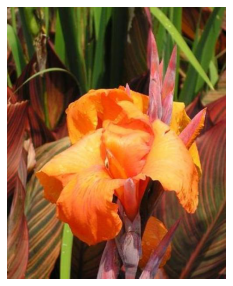

In [74]:
show_image(img)

Example transformation: 90 degree rotation one or more times

In [75]:
transform = A.RandomRotate90(p=1.0)

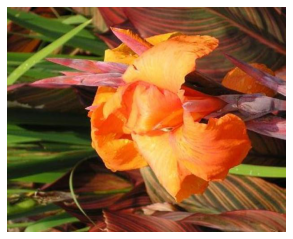

In [76]:
augmented_image = transform(image=img)['image']
show_image(augmented_image)

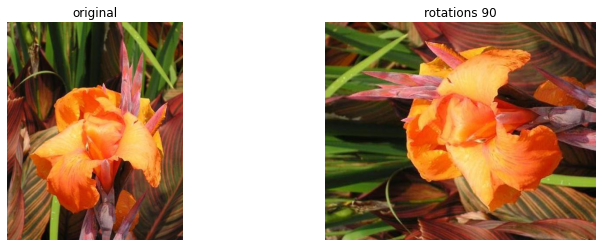

In [77]:
_, axs = plt.subplots(1, 2, figsize=(12, 4))
show_image(img, ctx=axs[0], title='original');
show_image(augmented_image, ctx=axs[1], title='rotations 90');

In [78]:
# Let's do a bunch of random augmentations
transform = A.Compose([
        A.Resize(224, 224), 
        A.RandomRotate90(),
        A.Flip(),
        A.Transpose(),
        A.OneOf([
            A.IAAAdditiveGaussianNoise(),
            A.GaussNoise(),
        ], p=0.2),
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.HueSaturationValue(p=0.3),
    ])

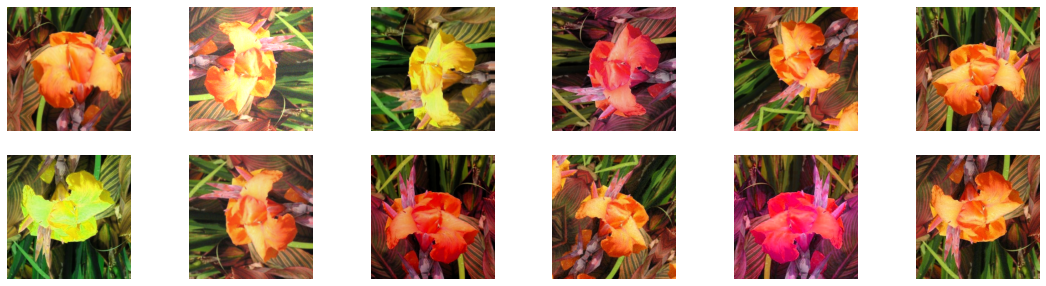

In [79]:
_, axs = plt.subplots(2, 6, figsize=(19, 5))
for ax in axs.flatten(): 
    augmented_image = transform(image=img)['image']
    show_image(augmented_image, ctx=ax);

**Note**: All the augmented images still belong to the same class as the original image.

### Rewriting Dataset with Augmenations

Let's upgrade our dataloader to support data augmentation

In [80]:
def open_image(fn: Path):
    img = PIL.Image.open(path/fn).convert('RGB')
    return np.array(img)
    
    
class FlowerDatset():
    def __init__(self,
                 df: pd.DataFrame, 
                 tfms: list,
                 imagenet_stats: tuple = (mean, std)):
        
        self.df    = df
        self.stats = imagenet_stats
        self.tfms  = tfms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = self.df.iloc[index]['fn']
        label    = self.df.iloc[index]['labels']
        img      = open_image(img_path)
        if self.tfms:  
            img =  self.tfms(image=img)['image'] # Apply transformation to image
        return img, label

In [81]:
from albumentations.pytorch import ToTensor

train_transforms  = A.Compose([
        A.Resize(224, 224), 
        A.RandomRotate90(),
        A.Flip(),
        A.Transpose(),
        A.OneOf([
            A.IAAAdditiveGaussianNoise(),
            A.GaussNoise(),
        ], p=0.2),
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.HueSaturationValue(p=0.3),
        A.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225], always_apply=True), # Always apply normalization
       ToTensor()
    ])


valid_transforms  = A.Compose([
        A.Resize(224, 224),
        A.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225], always_apply=True),
       ToTensor()
    ])

Instantiate datasets and create train and validation dataloaders

In [82]:

train_ds = FlowerDatset(df_train, train_transforms)
valid_ds = FlowerDatset(df_valid, valid_transforms)

bs = 32
num_workers = 2

# Create training dataloader
dl_train    = DataLoader(train_ds,
                         bs=batch_size, 
                         num_workers=num_workers, 
                         drop_last=True,
                         pin_memory=True, 
                         shufle=shuffle)

# Create validation dataloader
dl_valid    = DataLoader(valid_ds,
                         bs=batch_size * 2, 
                         num_workers=num_workers, 
                         drop_last=False,
                         pin_memory=True, 
                         shufle=False)

#combine train and validation dataloer
dls = DataLoaders(dl_train, dl_valid, device='cuda')




#combine train and validation dataloer
dls = DataLoaders(dl_train, dl_valid, device='cuda')

Since we are using data augmentation we can as well try using a slightly bigger model `mobilenet_v2` instead of our previous `resnet`

In [83]:
flower_model = models.mobilenet_v2(pretrained=True) # Nore: pretrained=True


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


Let's take a look at the model architecture

In [84]:
flower_model

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

As before we'll want to replace the last `Linear` layer with one that is comapatible with the number of classes in our problem:

From:
```python
nn.Linear(in_features=1280, out_features=1000)
```

To:
```python
nn.Linear(in_features=1280, out_features=102)
```

In [85]:
flower_model.classifier[1] = nn.Linear(in_features=1280, out_features=num_classes)

In [86]:
flower_model

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

That's it! The model is ready for training.

In [87]:
learn = Learner(dls,
                flower_model,
                metrics=[accuracy],
                opt_func= SGD,
                loss_func= nn.CrossEntropyLoss())

As before, let's use the automated procedure to select a reasonable `learning rate`

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=1.3182567499825382e-06)

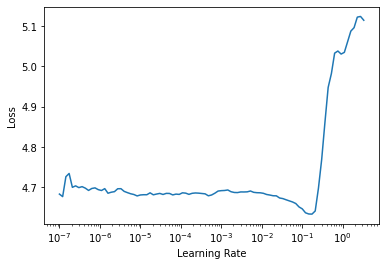

In [88]:
learn.lr_find()

In [89]:
learn.fit(n_epoch=10, lr=0.014)

epoch,train_loss,valid_loss,accuracy,time
0,4.474324,3.999079,0.210784,00:29
1,4.029316,3.245685,0.445098,00:28
2,3.536275,2.611353,0.623529,00:28
3,3.027905,2.101734,0.700000,00:27
4,2.552813,1.731353,0.772549,00:26
5,2.132322,1.465847,0.807843,00:27
6,1.780106,1.247484,0.826471,00:28
7,1.496650,1.081032,0.850000,00:27
8,1.252761,0.958694,0.849020,00:27
9,1.057372,0.872773,0.857843,00:26


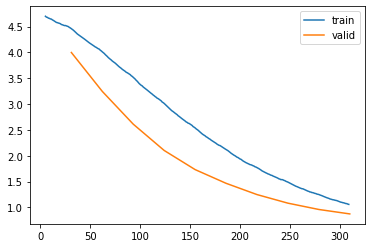

In [90]:
learn.recorder.plot_loss()

You can see our `valid loss` is smaller then `train_loss` which means we are not overfitting right now. Since we added a bit of augmentations and slightly bigger model we can train for a few more epoch so model can learn more effectively

In [91]:
learn.fit(n_epoch=5, lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.706580,0.862728,0.862745,00:28
1,0.686961,0.854313,0.863725,00:28
2,0.675400,0.847100,0.869608,00:27
3,0.679827,0.841555,0.867647,00:28
4,0.662820,0.838579,0.869608,00:27


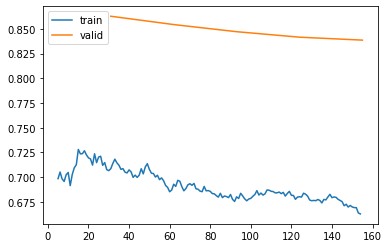

In [92]:
learn.recorder.plot_loss()

Let's take a look at some predictions again

In [93]:
y_hat, y = learn.get_preds()

In [94]:
y_hat.shape, y.shape

(torch.Size([1020, 102]), torch.Size([1020]))

In [95]:
accuracy(y_hat, y)

tensor(0.8696)

In [96]:
predictions = y_hat.max(dim=-1)[1]

In [97]:
predictions[:100]

tensor([ 89,  44,   4,  34,  79,  55,  21,  88,  47,  66,  43,  98,  83,  87,
          5, 100,  14,  27,  65,  96,  43,  61,  20,  13,  69,  91,  48,  24,
         90,  26,  40,  67,  52,  62,   8,  24,  91,  60,  51,  95,  48,  84,
         30,  47,  23,   1,  28,  16,  27,  41,  85,   0,  23,  66,  72, 100,
         41,  79,  45,  11,  35,  52,  84,  78,  24,  87,  34,  28,  64,  37,
         20,  58,  39,  94,  31,  27,  79,  69,  10,  92,   4,  81,  59,  21,
         58,  28,  18,   7,  91,  72,  80,  22,  53,  97,  15, 100,  84,  87,
         57,  36])

In [98]:
y[:100]

tensor([ 89,  44,   4,  34,  79,  55,  21,  50,  47,  66,  43,  98,   6,  87,
          5, 100,  14,  27,  65,  22,  43,  61,  20,  13,  69,  91,  48,  24,
         90,  26,  40,  67,  52,  62,   3,  24,  91,  60,  51,  95,  48,  42,
         30,  47,  23,   1,  28,  16,  27,  41,  85,   0,  89,  44,  72, 100,
         41,  79,  83,  11,  87,  52,  84,  78,  24,   3,  34,  28,  64,  37,
         20,  58,  39,  94,  31,  27,  79,  69,   3,  92,   4,  81,  59,  21,
         58,  76,  18,   7,  91,  72,  68,  22,  53,  96,  15, 100,  84,   3,
         57,  36])

In [99]:
predictions[:100] == y[:100]

tensor([ True,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False, False,  True,  True,  True,  True, False,  True,
        False,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
        False,  True,  True, False,  True,  True,  True, False,  True,  True])

Now let's also try training on a bigger dataset

In [100]:
print('df_train:', df_train.shape)
print('df_valid:', df_valid.shape)
print('df_test: ', df_test.shape)

df_train: (1020, 3)
df_valid: (1020, 2)
df_test:  (6149, 2)


In [101]:

train_ds = FlowerDatset(df_test, train_transforms) # Changed df_train to df_test here!!! That's the only change
valid_ds = FlowerDatset(df_valid, valid_transforms)

bs = 32
num_workers = 2

# Create training dataloader
dl_train    = DataLoader(train_ds,
                         bs=batch_size, 
                         num_workers=num_workers, 
                         drop_last=True,
                         pin_memory=True, 
                         shufle=shuffle)

# Create validation dataloader
dl_valid    = DataLoader(valid_ds,
                         bs=batch_size * 2, 
                         num_workers=num_workers, 
                         drop_last=False,
                         pin_memory=True, 
                         shufle=False)

#combine train and validation dataloer
dls = DataLoaders(dl_train, dl_valid, device='cuda')




#combine train and validation dataloer
dls = DataLoaders(dl_train, dl_valid, device='cuda')

In [102]:
flower_model = models.mobilenet_v2(pretrained=True) # Nore: pretrained=True

In [103]:
flower_model.classifier[1] = nn.Linear(in_features=1280, out_features=num_classes)

In [104]:
learn = Learner(dls,
                flower_model,
                metrics=[accuracy],
                opt_func= SGD,
                loss_func= nn.CrossEntropyLoss())

In [ ]:
learn.lr_find()

In [ ]:
learn.fit(n_epoch=10, lr=0.0174)

In [ ]:
learn.recorder.plot_loss()